In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from independence_models import *
from MLE_estimator_tellurium import *
import scipy
import sympy as sp
from datetime import datetime
import os

In [5]:
os.chdir('/home/user')
current_time = datetime.now()
timestamp_str = current_time.strftime('%Y%m%d_%H%M%S')
os.makedirs(timestamp_str, exist_ok=True)
os.chdir(timestamp_str)
print(os.getcwd())

/home/user/20241009_222122


To do:

- Split the time scale computation and plotting into separate functions?
- Have Polly upload the time scale function.
- ~~Have Jose upload the M2 calculation?~~ \(Probably not, becuse there is nothing in it that guarantees that it gives the minimal Markov basis!\)
- Make sure that all info is saved, and can be reovered.
- Add time stamps, so that info is not overwritten.

## Helper functions

In [7]:
def integer_basis_for_nullspace(A_np: np.ndarray):

    # Compute ZZ-basis with sympy
    A_sym = sp.Matrix(A_np)
    null_space = A_sym.nullspace()
    null_space_np = [np.array(vec).astype(int) for vec in null_space]
    B = np.hstack(null_space_np)

    # Turn into a QQ-basis (reduce to a linearly indepndent subset over QQ)
    # We do this through a QR decomposition
    Q, R, pivot_columns = scipy.linalg.qr(B, mode='economic', pivoting=True)
    r = np.linalg.matrix_rank(B)
    return B[:, pivot_columns[0:r]]

In [8]:
def timescales(Gamma,
               u=None,
               tfinal=1e3,
               n_timestep=750,
               u_rand_min=10,
               u_rand_max=50):

    Gamma_rk = te.rank(Gamma)

    if u is None:
        u = np.random.randint(u_rand_min, u_rand_max, size=(1, Gamma.shape[0]))

    te_model = write_tellurium_model_via_SBML(Gamma, return_runtime=False)

    MLE, _, _, _, _, eig = MLE_tellurium(Gamma,
                                         te_model,
                                         tfinal,
                                         n_timestep,
                                         u,
                                         eigenvalueAnalysis=True)

    eig_real = eig.real
    eig_imag = eig.imag
    eig_real_nonzero = eig_real[0:Gamma_rk]

    return 1 / abs(eig_real_nonzero)

In [6]:
def new_plot():
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})

In [9]:
def timescale_plot(T, scale='log', **kwargs):
    plt.plot(T, '.-', **kwargs)
    plt.xlabel(r'Index of eigenvalue $\lambda$')
    plt.ylabel('|Re($\lambda$)|${}^{-1}$ (timescale)')
    plt.yscale(scale)

## Independence models

In [10]:
a = 10
b = 10
A = independence_model(a, b)

model_str = f'independence_model_{a}_{b}'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')

In [11]:
# Markov basis (sorted so that the first columns form a full-rank matrix)
Gamma_mb = independence_model_markov_basis(a, b)
Q, R, pivot_columns = scipy.linalg.qr(Gamma_mb, mode='economic', pivoting=True)
Gamma_mb = Gamma_mb[:, pivot_columns]

u = np.random.randint(10, 50, size=(1, re.rank(Gamma_mb)))
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [12]:
number_of_m_values = 10
m_values = np.rint(
    np.linspace(te.rank(Gamma_mb), Gamma_mb.shape[1],
                number_of_m_values)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(m_values)))

0


1


2


3


4


5


6


7


8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


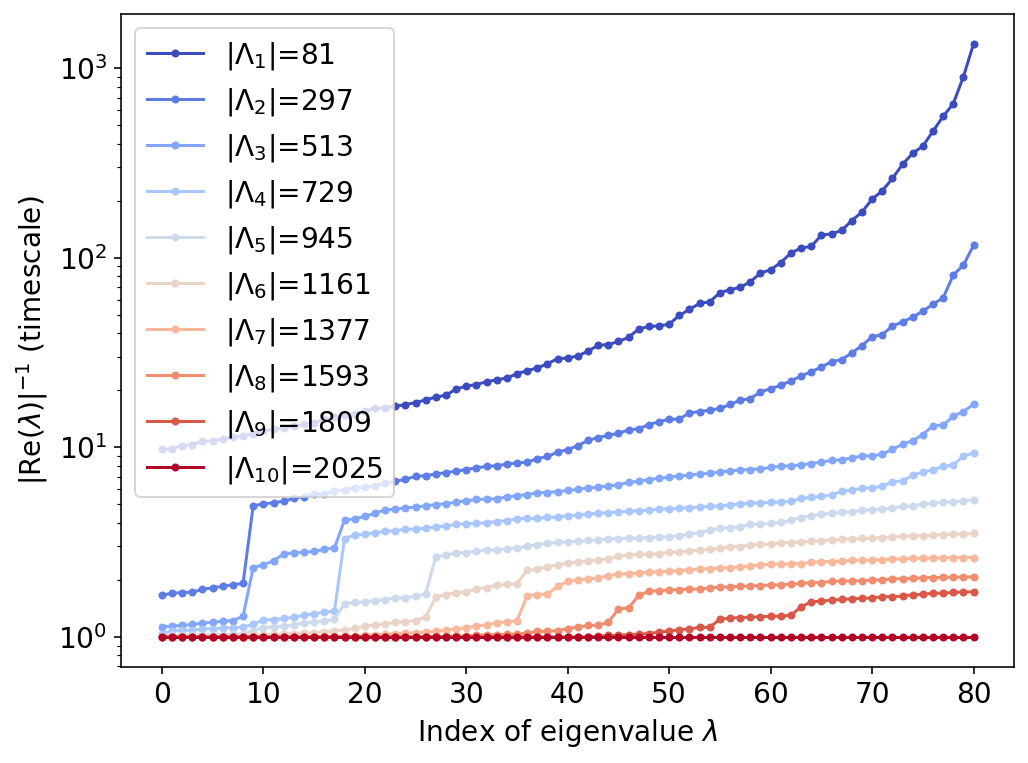

In [13]:
dir_name = f'towards_markov_basis'

os.makedirs(dir_name, exist_ok=True)

new_plot()

for i, m in enumerate(m_values):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Gamma_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    T = timescales(Gamma_mb[:, 0:m], u)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T,
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T, label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()
#plt.title(fr'Estimated time scales for $A_{{\mathrm{{ind}}}}({a},{b})$')
plt.savefig(dir_name + f'/independence_model_increasing_lambda.eps',
            format='eps')
plt.savefig(dir_name + f'/independence_model_increasing_lambda.pdf',
            format='pdf')
plt.show()

In [14]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Gamma_mb), dtype=int),
     np.random.choice(range(-2, 3),
                      size=(te.rank(Gamma_mb),
                            Gamma_mb.shape[1] - te.rank(Gamma_mb)))))
Gamma_spanning_set = np.dot(Gamma_mb[:, 0:te.rank(Gamma_mb)], extension_matrix)

new_plot()

for i, m in enumerate(m_values):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Gamma_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    T = timescales(Gamma_spanning_set[:, 0:m], u)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T,
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T, label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()

plt.savefig(dir_name +
            f"/independence_model_increasing_lambda_to_random_spanning.eps",
            format='eps')
plt.savefig(dir_name +
            f"/independence_model_increasing_lambda_to_random_spanning.pdf",
            format='pdf')

0


1


2


3


## 4-cycle

In [0]:
Gamma_mb = np.array([[0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1],
                     [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1, 0],
                     [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
                     [0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
                     [-1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
                     [0, -1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                     [-1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [1, -1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, -1],
                     [1, -1, 0, 0, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 1, -1],
                     [1, 0, -1, 0, 0, -1, 0, 1, -1, 0, 1, 0, 0, 1, 0, -1],
                     [0, 1, -1, 0, 0, -1, 1, 0, 0, -1, 1, 0, 0, 1, -1, 0],
                     [1, 0, 0, -1, -1, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0, -1],
                     [0, 1, 0, -1, -1, 0, 1, 0, 0, -1, 0, 1, 1, 0, -1, 0],
                     [0, 0, 1, -1, 0, 0, -1, 1, -1, 1, 0, 0, 1, -1, 0, 0],
                     [0, 0, 0, 0, 1, -1, -1, 1, -1, 1, 1, -1, 0, 0, 0,
                      0]]).transpose()

Q, R, pivot_columns = scipy.linalg.qr(Gamma_mb, mode='economic', pivoting=True)
Gamma_mb = Gamma_mb[:, pivot_columns]

A = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
              [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
              [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

u = np.random.randint(10, 50, size=(1, te.rank(Gamma_mb)))

In [0]:
model_str = f'4_cycle'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [0]:
number_of_m_values = 10
m_values = np.rint(
    np.linspace(te.rank(Gamma_mb), Gamma_mb.shape[1],
                number_of_m_values)).astype(int)

In [0]:
dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

for i, m in enumerate(m_values):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Gamma_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    T = timescales(Gamma_mb[:, 0:m], u)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T,
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T, label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()
plt.savefig(dir_name + "/4-cycle_model_increasing_lambda.eps", format='eps')
plt.savefig(dir_name + "/4-cycle_model_increasing_lambda.pdf", format='pdf')
plt.show()

In [0]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Gamma_mb), dtype=int),
     np.random.choice([-2, -1, 1, 2],
                      size=(te.rank(Gamma_mb),
                            Gamma_mb.shape[1] - te.rank(Gamma_mb)))))
Gamma_spanning_set = np.dot(Gamma_mb[:, 0:te.rank(Gamma_mb)], extension_matrix)

new_plot()

for i, m in enumerate(m_values):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Gamma_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    T = timescales(Gamma_spanning_set[:, 0:m], u)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T,
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T, label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()

plt.savefig(dir_name + "/4-cycle_increaasing_lambda_to_random_spanning.eps",
            format='eps')
plt.savefig(dir_name + "/4-cycle_increasing_lambda_to_random_spanning.pdf",
            format='pdf')